In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier as SparkRandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier as SparkDecisionTreeClassifier
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource

# Set seed for reproducibility
np.random.seed(5)
random_state = np.random.randint(0, 10000)

output_notebook()


In [2]:
# Create Spark session
spark = SparkSession.builder \
    .appName("Alzheimer's Disease Analysis") \
    .getOrCreate()

# Load the CSV file into a Spark DataFrame
file_path = "Resources/alzheimers_disease_data.csv"
alzheimers_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema of the DataFrame
alzheimers_df.printSchema()

# Convert to Pandas DataFrame
alzheimers_db = alzheimers_df.toPandas()

# Display basic information about the DataFrame
alzheimers_db.info()

# Display the first few rows of the DataFrame
alzheimers_db.head()


root
 |-- PatientID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Ethnicity: integer (nullable = true)
 |-- EducationLevel: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- AlcoholConsumption: double (nullable = true)
 |-- PhysicalActivity: double (nullable = true)
 |-- DietQuality: double (nullable = true)
 |-- SleepQuality: double (nullable = true)
 |-- FamilyHistoryAlzheimers: integer (nullable = true)
 |-- CardiovascularDisease: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Depression: integer (nullable = true)
 |-- HeadInjury: integer (nullable = true)
 |-- Hypertension: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- CholesterolTotal: double (nullable = true)
 |-- CholesterolLDL: double (nullable = true)
 |-- CholesterolHDL: double (nullable = true)
 |-- CholesterolTrig

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [3]:
# Separate target variable and features
X = alzheimers_db.drop(columns=['PatientID', 'Diagnosis', 'DoctorInCharge'])
y = alzheimers_db['Diagnosis']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
features = X.columns


Random Forest Accuracy: 0.9511627906976744
Random Forest Confusion Matrix:
 [[274   5]
 [ 16 135]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       279
           1       0.96      0.89      0.93       151

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.95       430
weighted avg       0.95      0.95      0.95       430



<Figure size 1000x700 with 0 Axes>

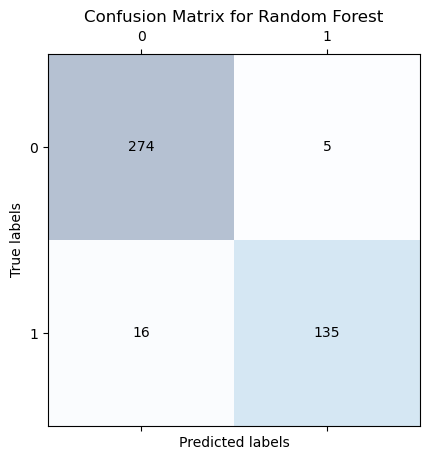

In [4]:
# Build Random Forest model
rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Display results
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)
print("Random Forest Classification Report:\n", class_report_rf)

# Plot confusion matrix for Random Forest
plt.figure(figsize=(10, 7))
plt.matshow(conf_matrix_rf, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix_rf.shape[0]):
    for j in range(conf_matrix_rf.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix_rf[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()


Decision Tree Accuracy: 0.8813953488372093
Decision Tree Confusion Matrix:
 [[250  29]
 [ 22 129]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       279
           1       0.82      0.85      0.83       151

    accuracy                           0.88       430
   macro avg       0.87      0.88      0.87       430
weighted avg       0.88      0.88      0.88       430



<Figure size 1000x700 with 0 Axes>

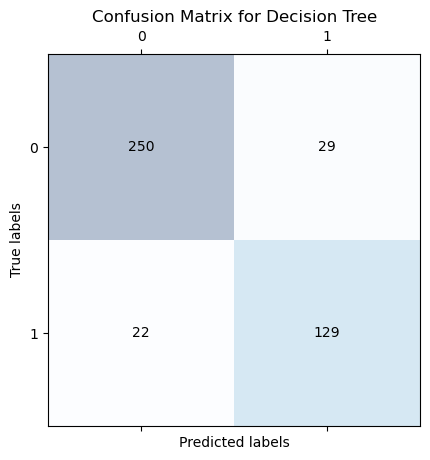

In [5]:
# Build Decision Tree model
dt = DecisionTreeClassifier(random_state=random_state)
dt.fit(X_train_scaled, y_train)

# Make predictions
y_pred_dt = dt.predict(X_test_scaled)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt)

# Display results
print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree Confusion Matrix:\n", conf_matrix_dt)
print("Decision Tree Classification Report:\n", class_report_dt)

# Plot confusion matrix for Decision Tree
plt.figure(figsize=(10, 7))
plt.matshow(conf_matrix_dt, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix_dt.shape[0]):
    for j in range(conf_matrix_dt.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix_dt[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Decision Tree')
plt.show()


### ROC (Receiver Operating Characteristic) Curve and AUC (Area Under the Curve)
The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier as its discrimination threshold is varied. The Area Under the Curve (AUC) measures the entire two-dimensional area underneath the entire ROC curve.

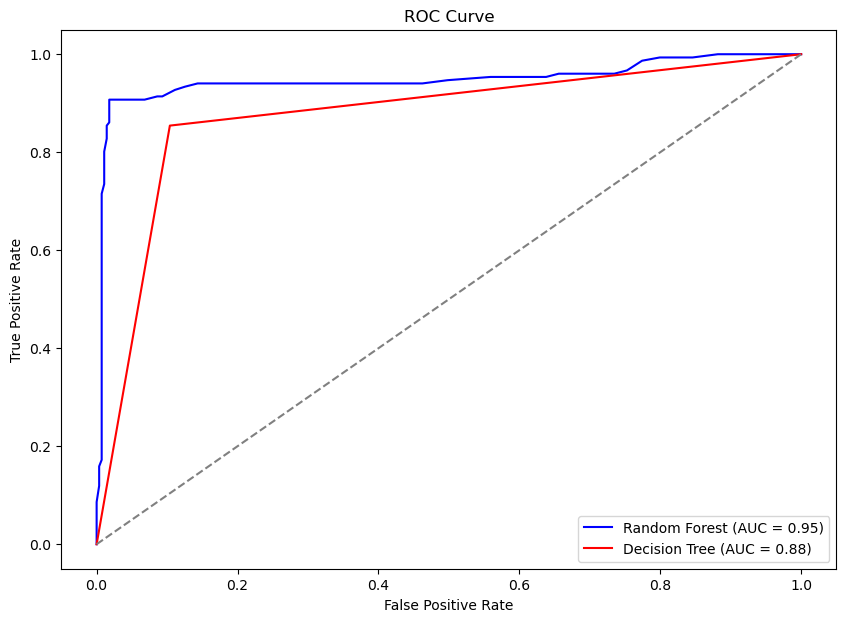

Random Forest AUC: 0.9477675710318308
Decision Tree AUC: 0.8751809917159202


In [6]:
# Compute ROC curve and AUC for Random Forest
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

# Compute ROC curve and AUC for Decision Tree
y_prob_dt = dt.predict_proba(X_test_scaled)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
auc_dt = roc_auc_score(y_test, y_prob_dt)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, color='red', label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("Random Forest AUC:", auc_rf)
print("Decision Tree AUC:", auc_dt)


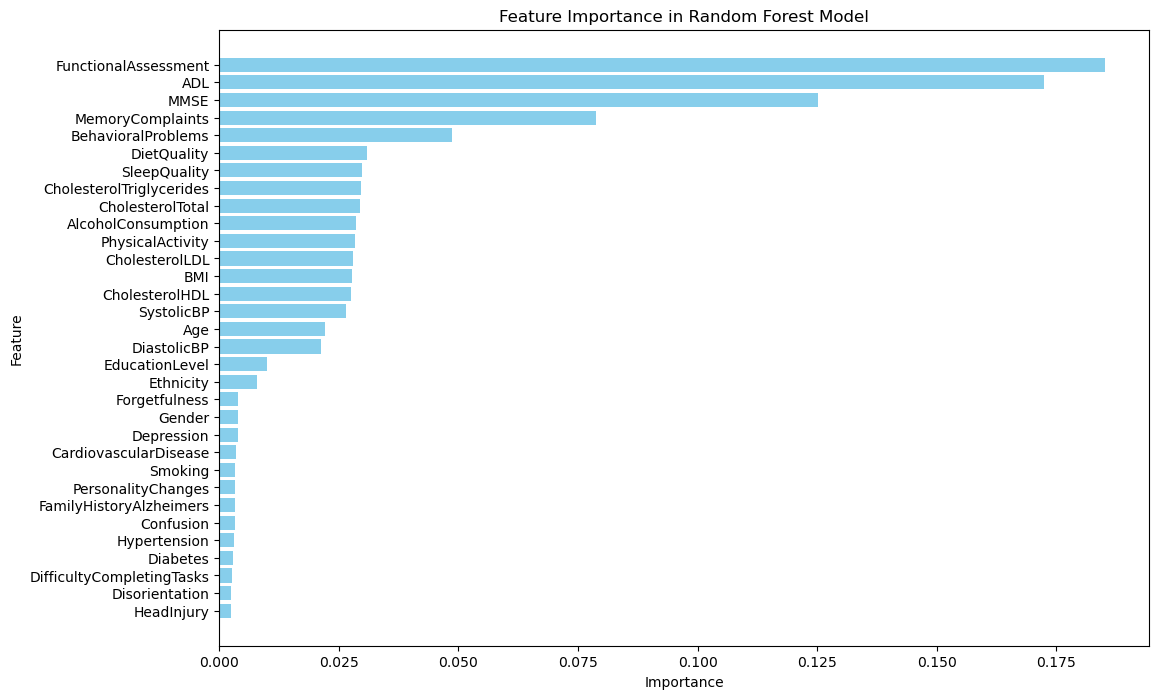

In [7]:
# Feature importance for Random Forest
importance_rf = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for the feature importance
feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_rf
})

# Sort the DataFrame by importance
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

# Plot the feature importance for Random Forest
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df_rf['Feature'], feature_importance_df_rf['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


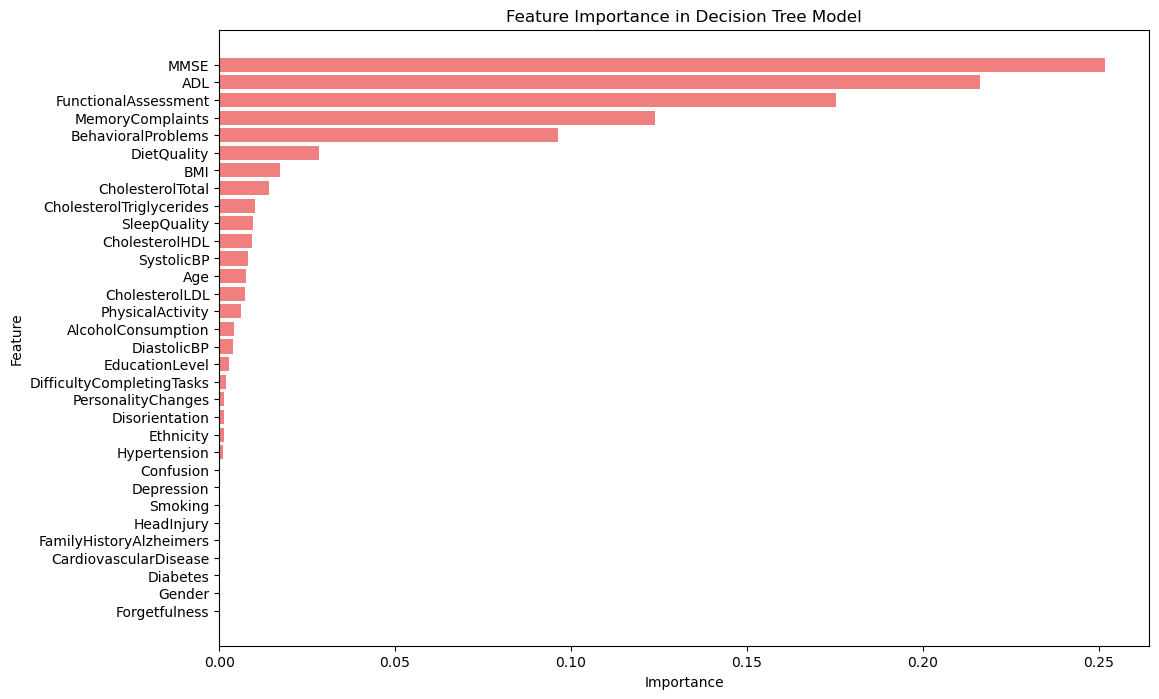

In [8]:
# Feature importance for Decision Tree
importance_dt = dt.feature_importances_
feature_importance_df_dt = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_dt
})

# Sort the DataFrame by importance
feature_importance_df_dt = feature_importance_df_dt.sort_values(by='Importance', ascending=False)

# Plot the feature importance for Decision Tree
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df_dt['Feature'], feature_importance_df_dt['Importance'], color='lightcoral')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()


In [9]:
# Overall model performance display
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest AUC:", auc_rf)
print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree AUC:", auc_dt)


Random Forest Accuracy: 0.9511627906976744
Random Forest AUC: 0.9477675710318308
Decision Tree Accuracy: 0.8813953488372093
Decision Tree AUC: 0.8751809917159202
